In [1]:
%matplotlib notebook
# %matplotlib inline
from adm_library import *

# Load desired poses

In [2]:
fname = 'files/SES-cold3-C4- 5DoF inputs_template.xlsx'
sheetname = 'Input for Tyler analysis'
spreadsheet = pd.read_excel(fname,
                            sheet_name=sheetname,skiprows=1,usecols='B:N')

focal_length = spreadsheet.iloc[0][0]-110 # focal length is track length -110mm, per TG
sMPA_to_WCS = spreadsheet.iloc[3,:3].astype(float)
sMPA_angle_to_WCS_deg = spreadsheet.iloc[6,:3].astype(float)
GSA_angle_WCS_deg = spreadsheet.iloc[7][0]
sMask=np.array(spreadsheet.iloc[10,1:4]).astype(float)

spreadsheet = pd.read_excel(fname,
                            sheet_name=sheetname,skiprows=15,usecols='B:N')
pose_actual = spreadsheet.iloc[0:9,0:6]
pose_actual = pose_actual.set_index('Name')
pose_actual.columns = ['X','Y','Z','Rx','Ry']
X_5DOF,Y_5DOF,Z_5DOF,rx_deg_5DOF,ry_deg_5DOF = [[*pose_actual['X'].values.astype(float)],[*pose_actual['Y'].values.astype(float)],[*pose_actual['Z'].values.astype(float)],
                                                [*pose_actual['Rx'].values.astype(float)],[*pose_actual['Ry'].values.astype(float)]]
pose_encoders = spreadsheet.iloc[0:9,7:13]
pose_encoders = pose_encoders.set_index('Name.1')




# Construct dataframe

<IPython.core.display.Javascript object>


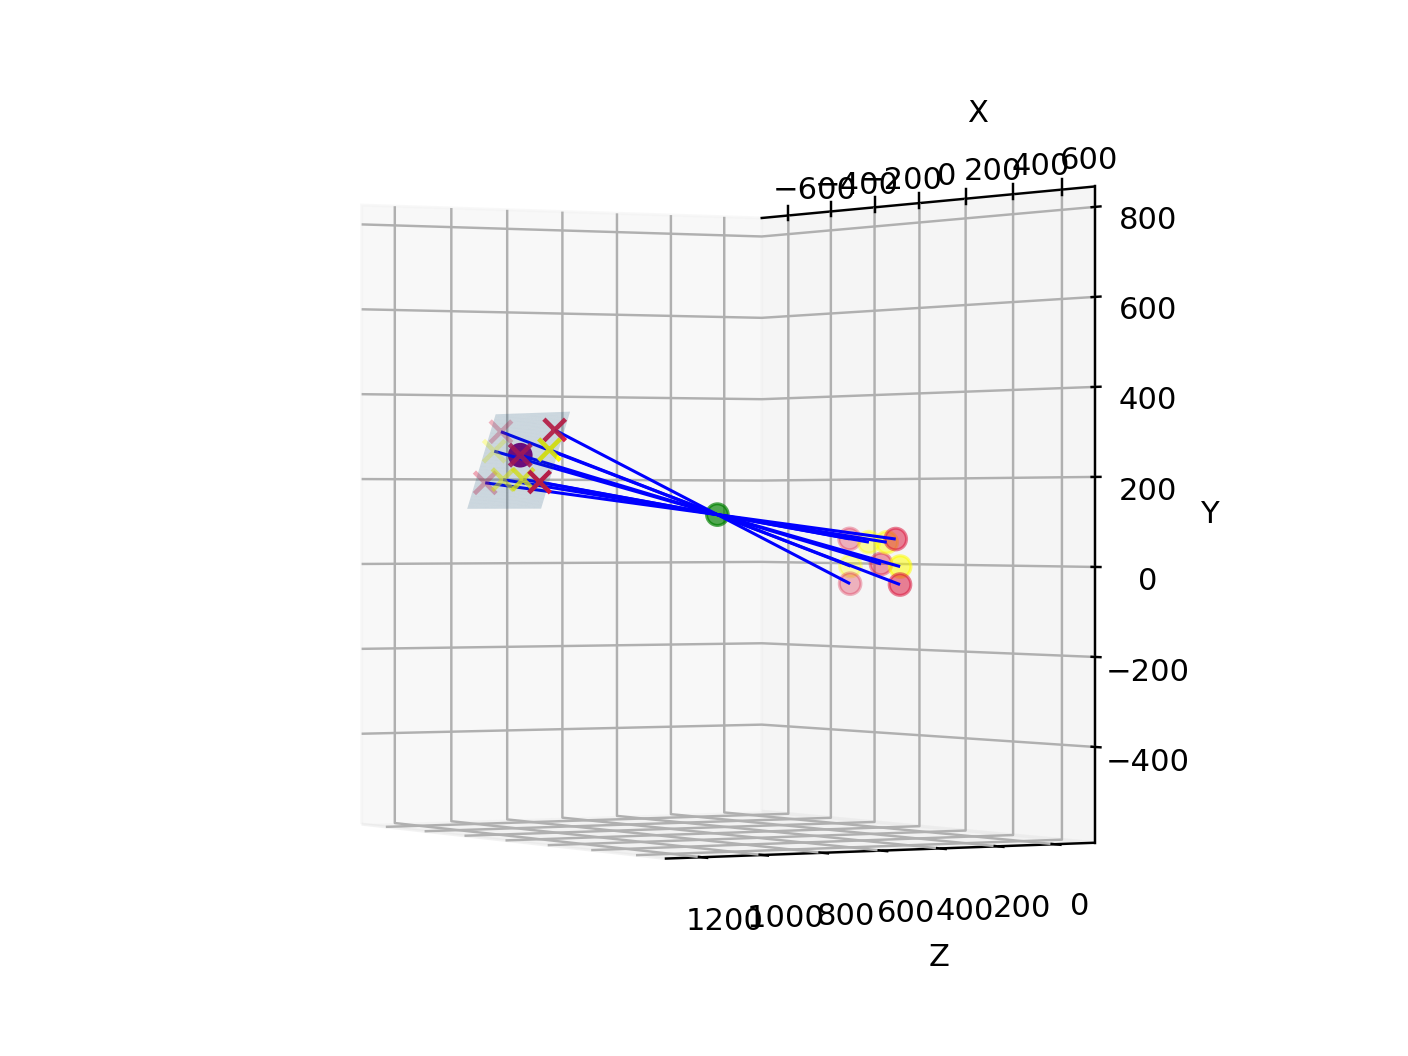

X           Y          Z         Rx         Ry    color  \
Name                                                                      
PDI1  -109.089755   -4.477723  21.386613  -0.941514  10.804298   yellow   
PDI2   111.429511   -3.828453  21.664246  -0.884323 -10.784784   yellow   
PDI3    39.795278   52.011229  11.044961   4.741583  -3.798262   yellow   
PDI4   -38.810833   51.903508  11.309534   4.728098   3.961031   yellow   
PR1      0.943594    1.280695  -0.338386   0.031453   0.035137  crimson   
PR2   -109.505749  -45.867074  22.370475  -4.911732  10.680266  crimson   
PR3    111.309055  -45.373337  22.058458  -4.857077 -10.600321  crimson   
PR4    103.076801   59.765562  30.696044   5.307985 -10.311998  crimson   
PR5    -101.43058    59.40225  30.809096   5.269783  10.410043  crimson   
sMask      1.3107  116.244531    587.154        NaN        NaN        g   
sMPA        1.736    249.4149  1267.7131 -24.291790   0.025500   purple   

           uvec_X      uvec_Y       uvec_Z       Rz  
Name                                                 
PDI1   242.214916  264.860490  1241.274628      NaN  
PDI2  -241.782625  263.638476  1241.619009      NaN  
PDI3   -85.594929  142.863551  1281.345137      NaN  
PDI4    89.257250  143.137547  1281.064648      NaN  
PR1      0.792405  248.143393  1268.071794      NaN  
PR2    239.466788  350.312004  1220.458522      NaN  
PR3   -237.694885  349.239187  1221.112189      NaN  
PR4   -231.300660  128.369032  1264.754223      NaN  
PR5    233.475701  129.171851  1264.272746      NaN  
sMask         NaN         NaN          NaN      NaN  
sMPA     0.000060    0.055685     0.123376  0.13536

In [3]:
#Generate a dataframe where we will store some parameters for each pose
columns = ['X','Y','Z','Rx','Ry']
df = pose_actual
df['color']='crimson'

gsa_rot = R.from_euler('X',GSA_angle_WCS_deg, degrees=True)
df.loc['sMask',['X','Y','Z']] = gsa_rot.apply(sMask)
df.loc['sMask','color'] = 'g'

df.loc['sMPA',['X','Y','Z']] = sMPA_to_WCS.values.astype(float)
df.loc['sMPA','color']='purple'

for pose in df.index:
    update_uvec(df,pose,length=focal_length,rotangle=GSA_angle_WCS_deg)
    if 'PDI' in pose:
        df.loc[pose,'color'] = 'yellow'

# create normal vector to sMPA
vec = np.array([0,0,1])*sMPA_angle_to_WCS_deg[-1] # the vector magnitude encodes the Z rotation in radians
rotmat = R.from_euler('XY',sMPA_angle_to_WCS_deg[:-1], degrees=True) # the vector components encode the direction in 5DOF
df.loc['sMPA',['uvec_X','uvec_Y','uvec_Z']] = rotmat.apply(vec)
df.loc['sMPA',['Rx','Ry','Rz']] = sMPA_angle_to_WCS_deg.values.astype(float)
ax = plot_poses(df)
plot_sMPA(df, ax)
df

# Ingest Manal's spreadsheet

In [4]:
summary = pd.read_excel('files/Shifts Summary CV test.xlsx',
                        sheet_name='CV test FDPR',skiprows=52,nrows=40,
                        usecols='B:R').dropna()

In [5]:
original_columns = summary.columns
summary['X'] = summary['HTSAX']
summary['Y'] = summary[['VTSAN','VTSAP']].mean(axis=1)
summary['Z'] = summary['HTSAZ']
summary['Rx'] = summary['GSARX']
summary['Ry'] = summary['GSARY']
summary

camera  det normal dz (um)  chief ray dz (um)    row    col  dx (px)  \
0     PR1               939.0              968.0  401.6  272.6    -47.4   
1     PR2              1012.0             1048.0  395.4  248.7    -71.3   
2     PR3               931.0              964.0  407.8  287.2    -32.8   
3     PR4               893.0             1051.0  387.9  288.5    -31.5   
4     PR5               894.0             1052.0  392.3  248.8    -71.2   
5     PR1               918.0              946.0  402.7  273.2    -46.8   
7     PR1                25.0               27.0  244.0  308.3    -11.7   
8     PR2                62.0               64.0  229.1  301.9    -18.1   
9     PR3                -1.0                0.0  238.9  307.0    -13.0   
10    PR4                37.0               45.0  234.1  310.1     -9.9   
11    PR5                -4.0               -3.0  240.9  303.9    -16.1   
12    PR1                25.0               26.0  242.3  309.9    -10.1   
14    PR1               -30.0              -31.0  250.0  313.9     -6.1   
15    PR2                13.0               14.0  236.0  308.0    -12.0   
16    PR3               -31.0              -31.0  246.3  318.5     -1.5   
17    PR4                -4.0               -3.0  241.1  316.9     -3.1   
18    PR5               -56.0              -65.0  247.2  309.0    -11.0   
19    PR1               -30.0              -31.0  251.0  309.2    -10.8   
21    PR1              -106.0             -108.0  282.0  322.0      2.0   
22    PR2               -62.0              -63.0  266.0  312.2     -7.8   
23    PR3              -103.0             -105.0  277.4  318.5     -1.5   
24    PR4               -87.0             -101.0  273.9  321.3      1.3   
25    PR5              -148.0             -172.0  279.5  313.0     -7.0   
26    PR1              -105.0             -107.0  283.1  322.0      2.0   
28    PR1               -54.0              -55.0  260.1  323.0      3.0   
29    PR2                -8.0               -8.0  239.8  305.1    -14.9   
30    PR3              -212.0             -218.0  279.0  322.0      2.0   
31    PR4              -204.0             -239.0  269.4  340.3     20.3   
32    PR5              -112.0             -130.0  241.0  330.1     10.1   
33    PR1               -55.0              -56.0  262.1  321.1      1.1   
35    PR1                 6.0                7.0  264.0  321.4      1.4   
36    PR2                37.0               39.0  250.2  313.0     -7.0   
37    PR3               -10.0              -10.0  263.9  318.3     -1.7   
38    PR4                32.0               39.0  258.8  320.6      0.6   
39    PR5                -3.0               -3.0  263.0  312.9     -7.1   

    dy (px)  dx (um)  dy (um)    FAMX  ...    HTSAZ    VTSAN    VTSAP   GSARX  \
0    -145.6   -474.0  -1456.0 -0.0281  ...   1.0869   0.9490   0.9493  0.0667   
1    -139.4   -713.0  -1394.0 -0.0255  ...  23.7411 -46.1831 -46.1839 -4.8724   
2    -151.8   -328.0  -1518.0 -0.0308  ...  23.5426 -45.6376 -45.6379 -4.8299   
3    -131.9   -315.0  -1319.0 -0.0301  ...  32.3237  59.4431  59.4430  5.3374   
4    -136.3   -712.0  -1363.0 -0.0266  ...  32.3296  59.0344  59.0350  5.3109   
5    -146.7   -468.0  -1467.0 -0.0306  ...   1.0853   0.9503   0.9498  0.0669   
7      12.0   -117.0    120.0 -0.0301  ...  -0.3455   1.5705   1.5709  0.0373   
8      26.9   -181.0    269.0 -0.0263  ...  22.3473 -45.5472 -45.5466 -4.9018   
9      17.1   -130.0    171.0 -0.0320  ...  22.1178 -45.0082 -45.0083 -4.8592   
10     21.9    -99.0    219.0 -0.0317  ...  30.8418  60.0769  60.0772  5.3080   
11     15.1   -161.0    151.0 -0.0275  ...  30.8795  59.6729  59.6731  5.2818   
12     13.7   -101.0    137.0 -0.0311  ...  -0.3470   1.5714   1.5706  0.0369   
14      6.0    -61.0     60.0 -0.0318  ...  -0.3866   1.5560   1.5568  0.0397   
15     20.0   -120.0    200.0 -0.0255  ...  22.3080 -45.5621 -45.5628 -4.8988   
16      9.7    -15.0     97.0 -0.0313  ...  22.0859 -45.0280 -45.0278 -4.8569   
17    

## Reconstruct all the poses

In [6]:
summary_5DOF = pd.DataFrame(columns=summary.columns)
for i in range(len(summary)):
    summary_5DOF = pd.concat([summary_5DOF,calculate_5DOF_from_encoders(pd.DataFrame(summary.iloc[i]).T)])

for col in original_columns:
    summary_5DOF[col] = summary[col]
summary_5DOF

camera  det normal dz (um)  chief ray dz (um)    row    col  dx (px)  \
0     PR1               939.0              968.0  401.6  272.6    -47.4   
1     PR2              1012.0             1048.0  395.4  248.7    -71.3   
2     PR3               931.0              964.0  407.8  287.2    -32.8   
3     PR4               893.0             1051.0  387.9  288.5    -31.5   
4     PR5               894.0             1052.0  392.3  248.8    -71.2   
5     PR1               918.0              946.0  402.7  273.2    -46.8   
7     PR1                25.0               27.0  244.0  308.3    -11.7   
8     PR2                62.0               64.0  229.1  301.9    -18.1   
9     PR3                -1.0                0.0  238.9  307.0    -13.0   
10    PR4                37.0               45.0  234.1  310.1     -9.9   
11    PR5                -4.0               -3.0  240.9  303.9    -16.1   
12    PR1                25.0               26.0  242.3  309.9    -10.1   
14    PR1               -30.0              -31.0  250.0  313.9     -6.1   
15    PR2                13.0               14.0  236.0  308.0    -12.0   
16    PR3               -31.0              -31.0  246.3  318.5     -1.5   
17    PR4                -4.0               -3.0  241.1  316.9     -3.1   
18    PR5               -56.0              -65.0  247.2  309.0    -11.0   
19    PR1               -30.0              -31.0  251.0  309.2    -10.8   
21    PR1              -106.0             -108.0  282.0  322.0      2.0   
22    PR2               -62.0              -63.0  266.0  312.2     -7.8   
23    PR3              -103.0             -105.0  277.4  318.5     -1.5   
24    PR4               -87.0             -101.0  273.9  321.3      1.3   
25    PR5              -148.0             -172.0  279.5  313.0     -7.0   
26    PR1              -105.0             -107.0  283.1  322.0      2.0   
28    PR1               -54.0              -55.0  260.1  323.0      3.0   
29    PR2                -8.0               -8.0  239.8  305.1    -14.9   
30    PR3              -212.0             -218.0  279.0  322.0      2.0   
31    PR4              -204.0             -239.0  269.4  340.3     20.3   
32    PR5              -112.0             -130.0  241.0  330.1     10.1   
33    PR1               -55.0              -56.0  262.1  321.1      1.1   
35    PR1                 6.0                7.0  264.0  321.4      1.4   
36    PR2                37.0               39.0  250.2  313.0     -7.0   
37    PR3               -10.0              -10.0  263.9  318.3     -1.7   
38    PR4                32.0               39.0  258.8  320.6      0.6   
39    PR5                -3.0               -3.0  263.0  312.9     -7.1   

    dy (px)  dx (um)  dy (um)    FAMX  ...    HTSAZ    VTSAN    VTSAP   GSARX  \
0    -145.6   -474.0  -1456.0 -0.0281  ...   1.0869   0.9490   0.9493  0.0667   
1    -139.4   -713.0  -1394.0 -0.0255  ...  23.7411 -46.1831 -46.1839 -4.8724   
2    -151.8   -328.0  -1518.0 -0.0308  ...  23.5426 -45.6376 -45.6379 -4.8299   
3    -131.9   -315.0  -1319.0 -0.0301  ...  32.3237  59.4431  59.4430  5.3374   
4    -136.3   -712.0  -1363.0 -0.0266  ...  32.3296  59.0344  59.0350  5.3109   
5    -146.7   -468.0  -1467.0 -0.0306  ...   1.0853   0.9503   0.9498  0.0669   
7      12.0   -117.0    120.0 -0.0301  ...  -0.3455   1.5705   1.5709  0.0373   
8      26.9   -181.0    269.0 -0.0263  ...  22.3473 -45.5472 -45.5466 -4.9018   
9      17.1   -130.0    171.0 -0.0320  ...  22.1178 -45.0082 -45.0083 -4.8592   
10     21.9    -99.0    219.0 -0.0317  ...  30.8418  60.0769  60.0772  5.3080   
11     15.1   -161.0    151.0 -0.0275  ...  30.8795  59.6729  59.6731  5.2818   
12     13.7   -101.0    137.0 -0.0311  ...  -0.3470   1.5714   1.5706  0.0369   
14      6.0    -61.0     60.0 -0.0318  ...  -0.3866   1.5560   1.5568  0.0397   
15     20.0   -120.0    200.0 -0.0255  ...  22.3080 -45.5621 -45.5628 -4.8988   
16      9.7    -15.0     97.0 -0.0313  ...  22.0859 -45.0280 -45.0278 -4.8569   
17    

In [7]:
for pose in summary_5DOF.index:
    update_uvec(summary_5DOF,pose,length=focal_length,rotangle=GSA_angle_WCS_deg)
summary_5DOF['color'] = 'blue'
summary_5DOF.loc['sMask'] = df.loc['sMask']
summary_5DOF.loc['sMPA'] = df.loc['sMPA']
check_pupil_crossing([summary_5DOF])

       sMask to chief ray (mm)  sMask to origin (mm)
0                     1.032349            597.363025
1                     1.209333            596.853362
2                     1.080523            596.730050
3                     0.856547            567.100583
4                     1.034028            567.333530
5                     1.037917            597.364419
7                     0.258795            598.645338
8                     0.266916            597.966441
9                     0.260210            597.928656
10                    0.259228            568.510272
11                    0.257293            568.657425
12                    0.266234            598.646748
14                    0.210405            598.688273
15                    0.211949            597.996830
16                    0.207065            597.975733
17                    0.209214            568.551496
18                    0.203899            568.683110
19                    0.211571            598.

In [8]:
summary_5DOF

camera  det normal dz (um)  chief ray dz (um)    row    col  dx (px)  \
0        PR1               939.0              968.0  401.6  272.6    -47.4   
1        PR2              1012.0             1048.0  395.4  248.7    -71.3   
2        PR3               931.0              964.0  407.8  287.2    -32.8   
3        PR4               893.0             1051.0  387.9  288.5    -31.5   
4        PR5               894.0             1052.0  392.3  248.8    -71.2   
5        PR1               918.0              946.0  402.7  273.2    -46.8   
7        PR1                25.0               27.0  244.0  308.3    -11.7   
8        PR2                62.0               64.0  229.1  301.9    -18.1   
9        PR3                -1.0                0.0  238.9  307.0    -13.0   
10       PR4                37.0               45.0  234.1  310.1     -9.9   
11       PR5                -4.0               -3.0  240.9  303.9    -16.1   
12       PR1                25.0               26.0  242.3  309.9    -10.1   
14       PR1               -30.0              -31.0  250.0  313.9     -6.1   
15       PR2                13.0               14.0  236.0  308.0    -12.0   
16       PR3               -31.0              -31.0  246.3  318.5     -1.5   
17       PR4                -4.0               -3.0  241.1  316.9     -3.1   
18       PR5               -56.0              -65.0  247.2  309.0    -11.0   
19       PR1               -30.0              -31.0  251.0  309.2    -10.8   
21       PR1              -106.0             -108.0  282.0  322.0      2.0   
22       PR2               -62.0              -63.0  266.0  312.2     -7.8   
23       PR3              -103.0             -105.0  277.4  318.5     -1.5   
24       PR4               -87.0             -101.0  273.9  321.3      1.3   
25       PR5              -148.0             -172.0  279.5  313.0     -7.0   
26       PR1              -105.0             -107.0  283.1  322.0      2.0   
28       PR1               -54.0              -55.0  260.1  323.0      3.0   
29       PR2                -8.0               -8.0  239.8  305.1    -14.9   
30       PR3              -212.0             -218.0  279.0  322.0      2.0   
31       PR4              -204.0             -239.0  269.4  340.3     20.3   
32       PR5              -112.0             -130.0  241.0  330.1     10.1   
33       PR1               -55.0              -56.0  262.1  321.1      1.1   
35       PR1                 6.0                7.0  264.0  321.4      1.4   
36       PR2                37.0               39.0  250.2  313.0     -7.0   
37       PR3               -10.0              -10.0  263.9  318.3     -1.7   
38       PR4                32.0               39.0  258.8  320.6      0.6   
39       PR5                -3.0               -3.0  263.0  312.9     -7.1   
sMask    NaN                 NaN                NaN    NaN    NaN      NaN   
sMPA     NaN                 NaN                NaN    NaN    NaN      NaN   

       dy (px)  dx (um)  dy (um)    FAMX  ...    GSARY           X  \
0       -145.6   -474.0  -1456.0 -0.0281  ...   0.0271    0.680815   
1       -139.4   -713.0  -1394.0 -0.0255  ...  10.6751 -109.777556   
2       -151.8   -328.0  -1518.0 -0.0308  ... -10.6052  111.045141   
3       -131.9   -315.0  -1319.0 -0.0301  ... -10.3243  102.803957   
4       -136.3   -712.0  -1363.0 -0.0266  ...  10.3979 -101.710114   
5       -146.7   -468.0  -1467.0 -0.0306  ...   0.0261    0.677712   
7         12.0   -117.0    120.0 -0.0301  ...   0.0354    0.818039   
8         26.9   -181.0    269.0 -0.0263  ...  10.6828 -109.633695   
9         17.1   -130.0    171.0 -0.0320  ... -10.5975  111.188175   
10        21.9    -99.0    219.0 -0.0317  ... -10.3161  102.948745   
11        15.1   -161.0    151.0 -0.0275  ...  10.4051 -101.559395   
12        13.7   -101.0    137.0 -0.0311  ...   0.0346    0.819839   
14         6.0    -61.0     60.0 -0.0318  ...   0.0339    0.878646   
15        20.0   -120.0    200.0 -0.0255  ...  10.6817 -109.5

/var/folders/5y/l__pg2lx6mx_sq2b9d_kdpm40000gp/T/ipykernel_92574/3982242995.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset.loc['sMask'] = df.loc['sMask']
/var/folders/5y/l__pg2lx6mx_sq2b9d_kdpm40000gp/T/ipykernel_92574/3982242995.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset.loc['sMPA'] = df.loc['sMPA']


<IPython.core.display.Javascript object>


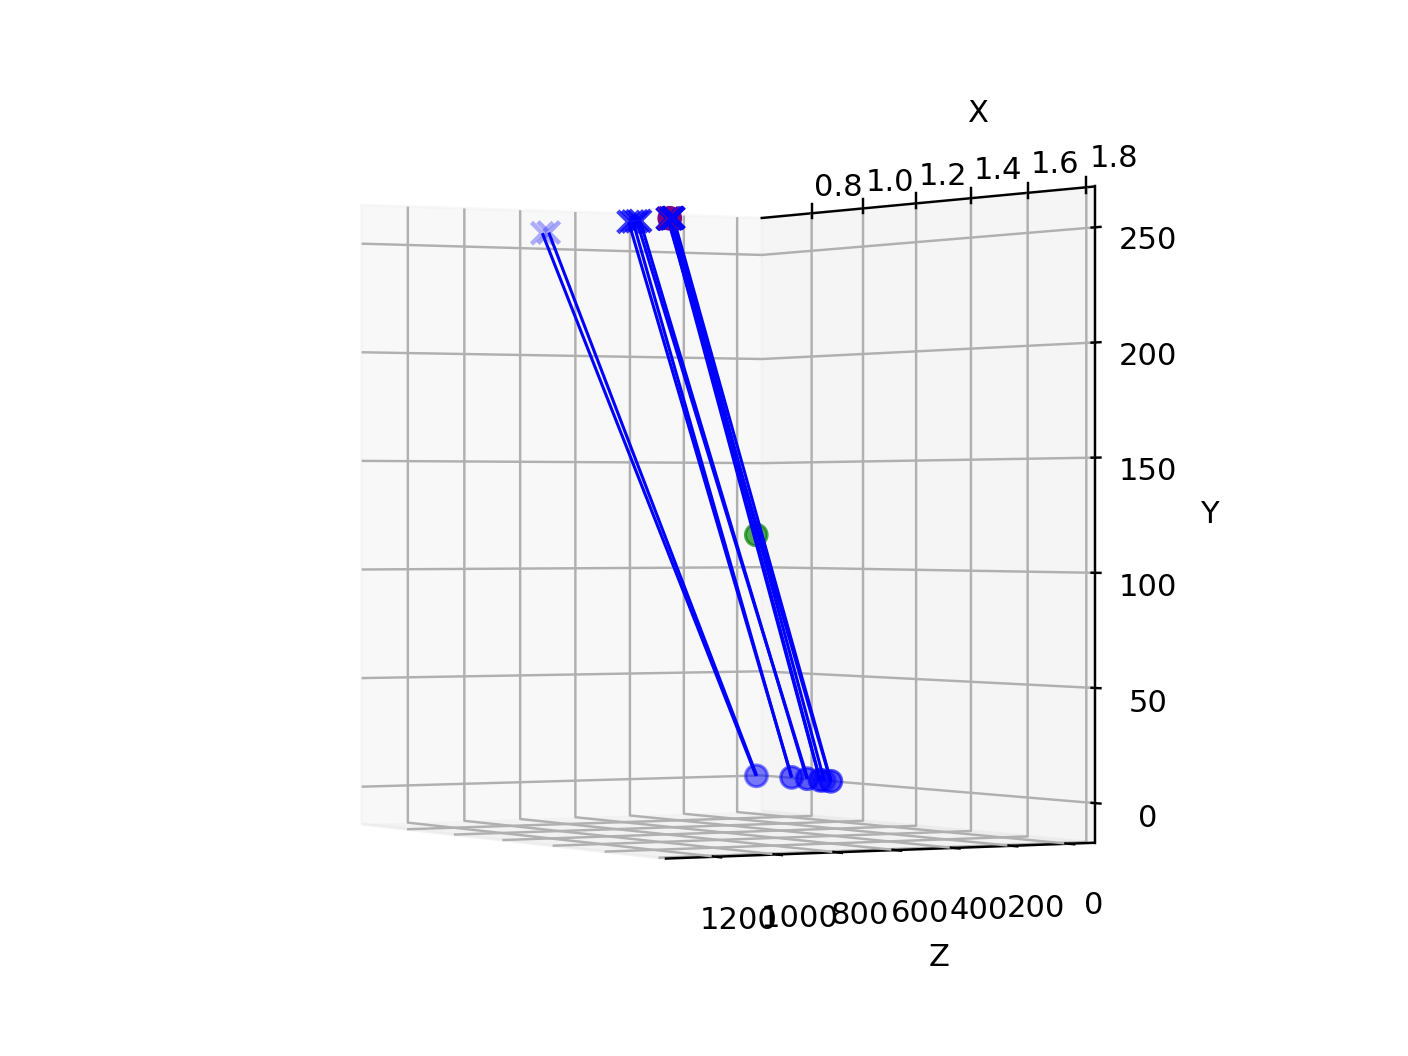

<Axes3D: xlabel='X', ylabel='Y', zlabel='Z'>

In [9]:

subset = summary_5DOF[summary_5DOF['camera']=='PR1']
subset.loc['sMask'] = df.loc['sMask']
subset.loc['sMPA'] = df.loc['sMPA']
plot_poses_no_extent(subset)

# now create error vectors

In [10]:
pose = summary_5DOF.loc[0]
sMPA_rotmat = R.from_euler('XYZ',df.loc['sMPA',['Rx','Ry','Rz']].values.astype(float), degrees=True)
center_sMPA = df.loc['sMPA',['X','Y','Z']].values.astype(float)

def create_error_vector(pose):
    endpt_X = pose['X']+pose['uvec_X']
    endpt_Y = pose['Y']+pose['uvec_Y']
    endpt_Z = pose['Z']+pose['uvec_Z']
    endpt = pose[['X','Y','Z']].values.astype(float)+pose[['uvec_X','uvec_Y','uvec_Z']].values.astype(float)
    dz = pose['chief ray dz (um)']/1000.
    vec = pose[['uvec_X','uvec_Y','uvec_Z']].values.astype(float)
    normvec = vec/np.linalg.norm(vec)
    newvec1 = endpt - normvec*dz
    dxdy = np.array([pose['dx (um)'],pose['dy (um)'],0.])/1000.
    newvec2 = newvec1 - sMPA_rotmat.apply(dxdy)
    return newvec2


def create_error_vector2(pose):
    center = center_sMPA+sMPA_rotmat.apply(PRcenters[pose['camera']])
    dxdy = np.array([pose['dx (um)'],pose['dy (um)'],0.])/1000.
    center -= sMPA_rotmat.apply(dxdy)
    newvec = center - pose[['X','Y','Z']].values.astype(float)
    normvec = newvec/np.linalg.norm(newvec)
    dz = pose['chief ray dz (um)']/1000.
    newvec1 = center + normvec*dz
    
    return newvec1

for pose in summary_5DOF.index:
    if pose not in ['sMask','sMPA']:
        summary_5DOF.loc[pose,['uvec_dx','uvec_dy','uvec_dz']] = create_error_vector(summary_5DOF.loc[pose])

<IPython.core.display.Javascript object>


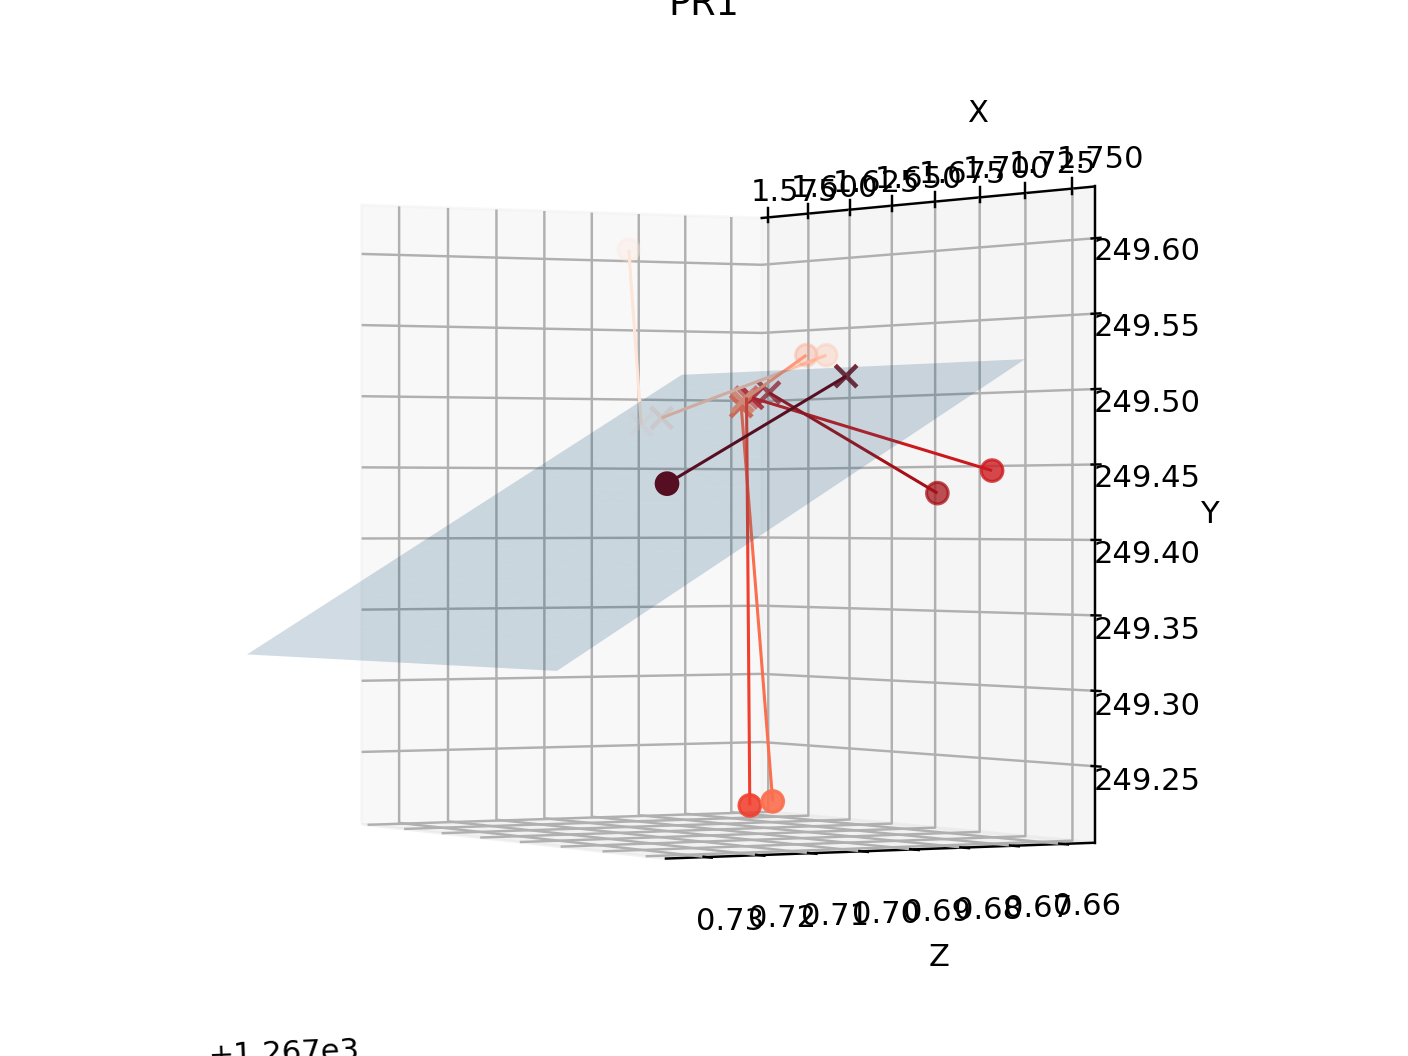

PR1
     uvec_dx     uvec_dy      uvec_dz
12  1.684313  249.476954  1267.716808
14  1.687255  249.481479  1267.713743
19  1.722047  249.491490  1267.709541
21  1.721042  249.488124  1267.709454
26  1.711398  249.494440  1267.705086
28  1.719334  249.493789  1267.706729
33  1.717006  249.497464  1267.702568
35  1.731828  249.508148  1267.692475
Radius of sphere that englobes all points (mm)
0.03256832470003507


<IPython.core.display.Javascript object>


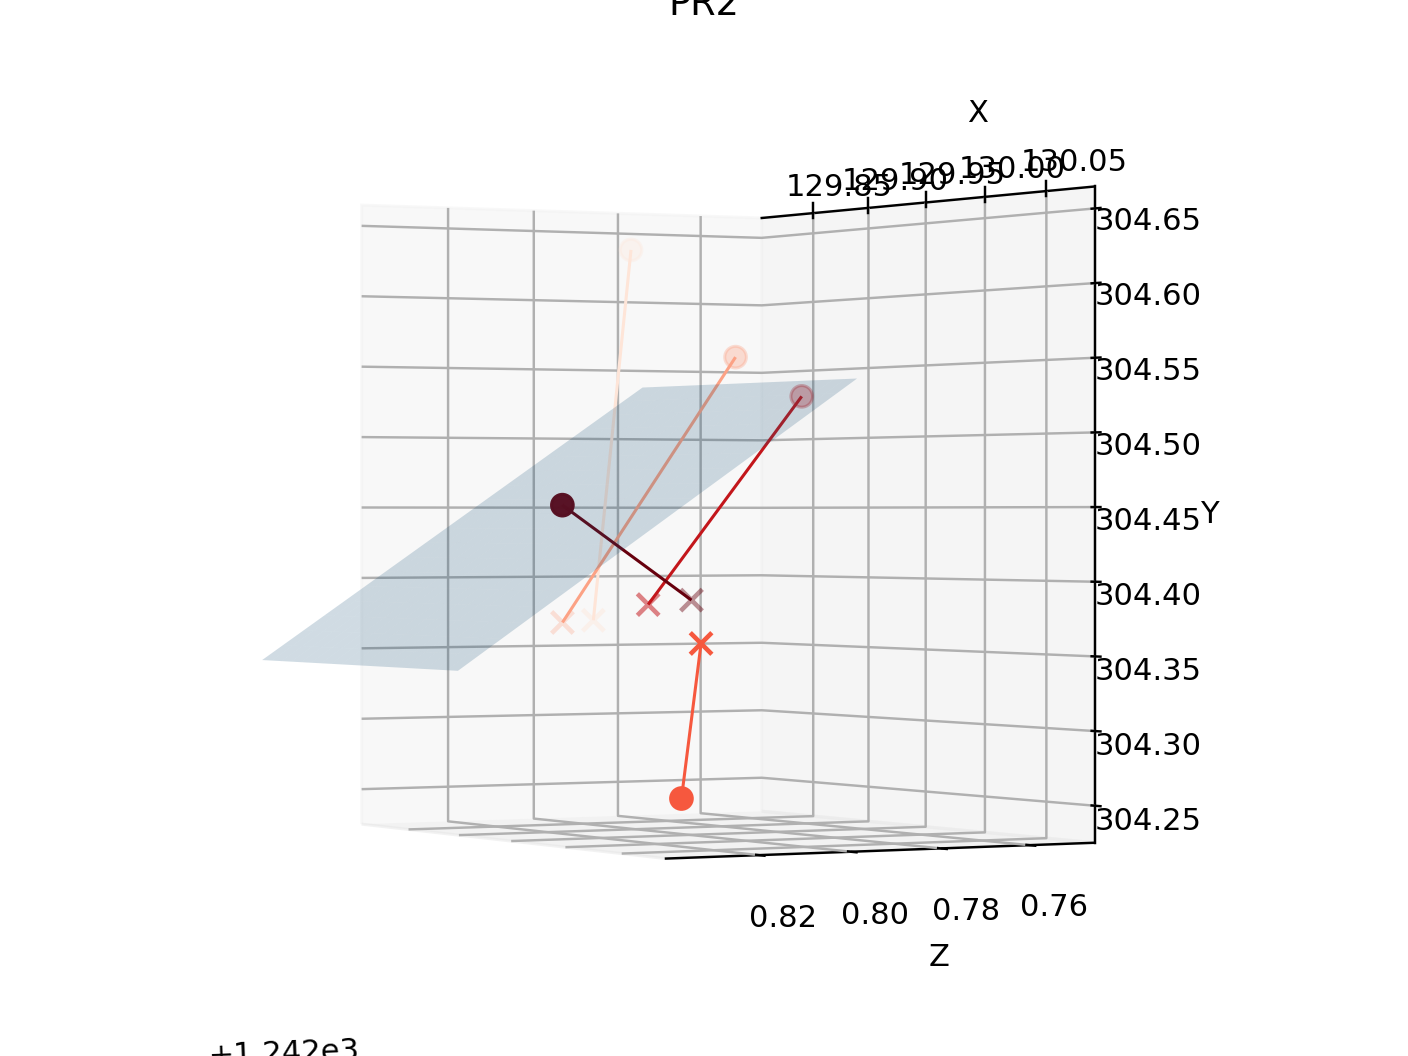

PR2
       uvec_dx     uvec_dy      uvec_dz
8   129.989807  304.374563  1242.831301
15  129.972006  304.372715  1242.833784
22  130.069774  304.361525  1242.827768
29  130.013072  304.385364  1242.825022
36  130.013054  304.388049  1242.815517
Radius of sphere that englobes all points (mm)
0.06012199412643307


<IPython.core.display.Javascript object>


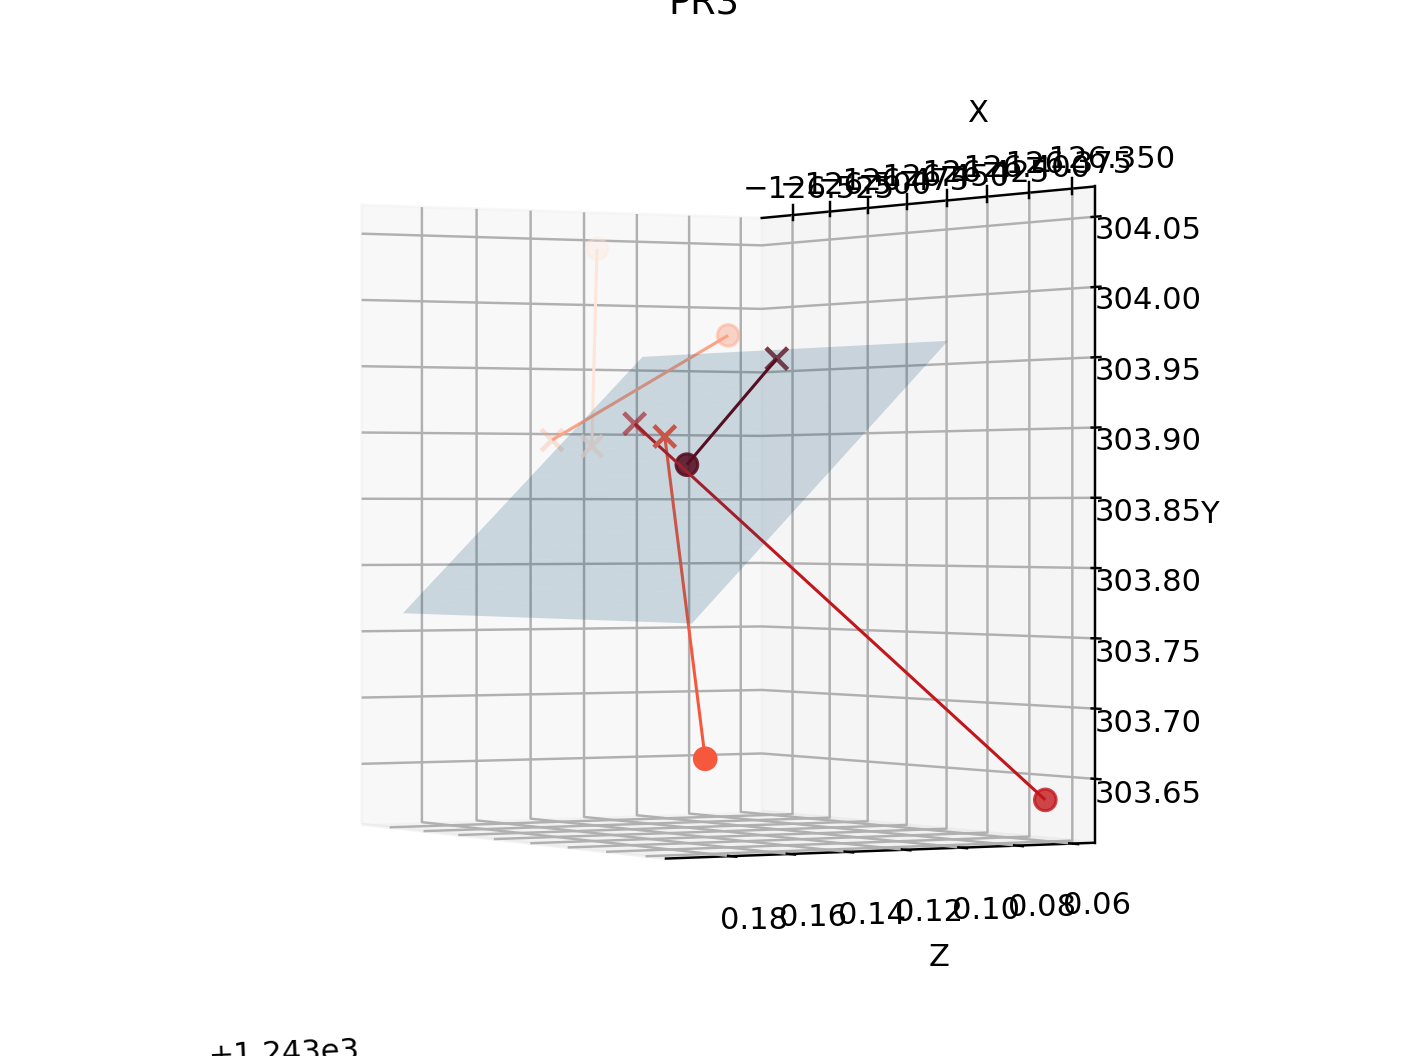

PR3
       uvec_dx     uvec_dy      uvec_dz
9  -126.402485  303.886213  1243.192253
16 -126.468636  303.892697  1243.171853
23 -126.366436  303.892146  1243.186446
30 -126.411250  303.902735  1243.172798
37 -126.374507  303.948001  1243.143253
Radius of sphere that englobes all points (mm)
0.06504406500976997


<IPython.core.display.Javascript object>


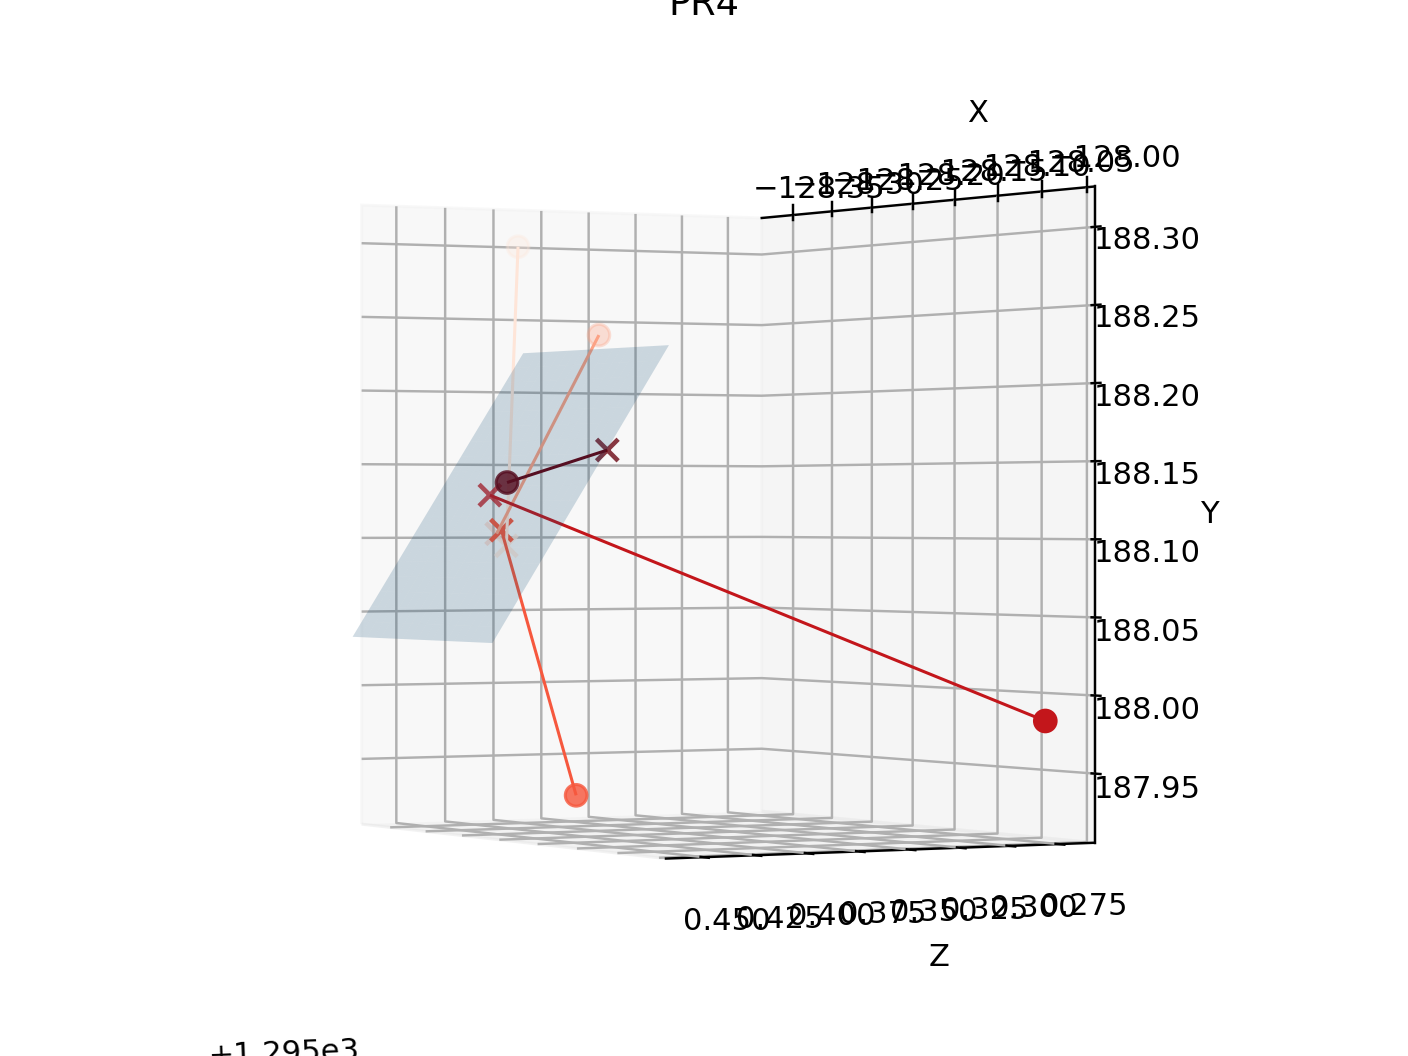

PR4
       uvec_dx     uvec_dy      uvec_dz
10 -128.258226  188.095234  1295.442575
17 -128.303925  188.103006  1295.430556
24 -128.238760  188.105605  1295.452237
31 -128.263176  188.128635  1295.448975
38 -128.225068  188.158359  1295.404502
Radius of sphere that englobes all points (mm)
0.060551096831706994


<IPython.core.display.Javascript object>


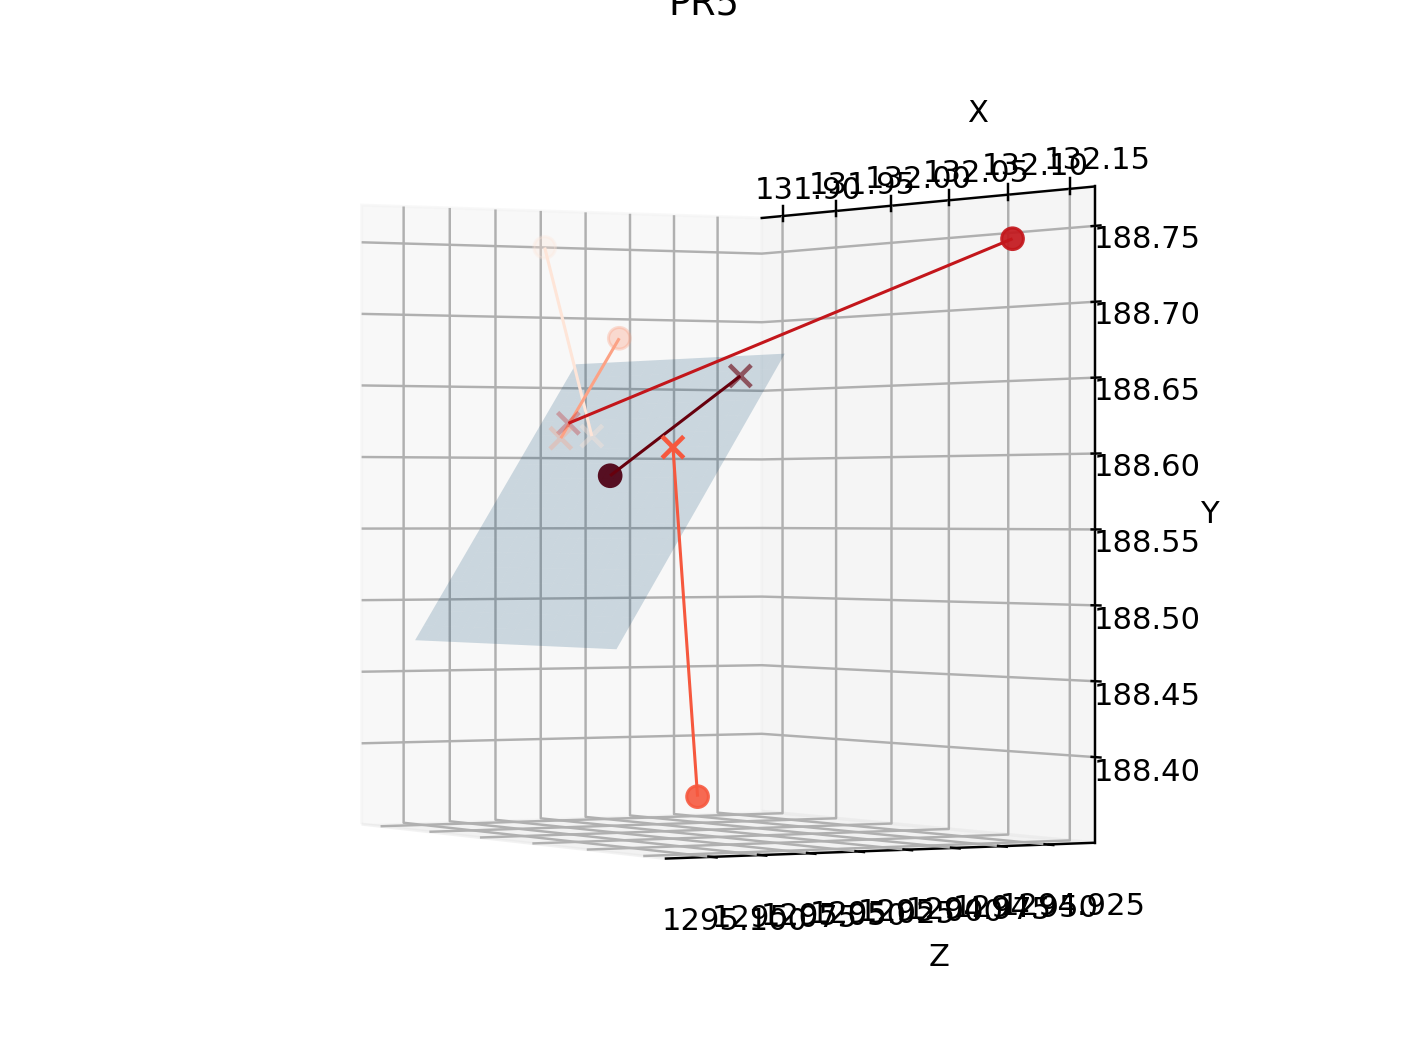

PR5
       uvec_dx     uvec_dy      uvec_dz
11  132.060427  188.611434  1295.097769
18  132.049364  188.610187  1295.107598
25  132.151185  188.602561  1295.108353
32  132.047560  188.620110  1295.102679
39  132.121727  188.649772  1295.056624
Radius of sphere that englobes all points (mm)
0.0685232422480441


In [11]:
good_circuits = summary_5DOF[7:]

for camera in [f'PR{i}' for i in range(1,6)]:
    subset = good_circuits[good_circuits['camera']==camera]
    ax = plot_whiskers(subset)
    meanloc = subset[['uvec_dx','uvec_dy','uvec_dz']].mean()
    ax.set_title(camera)
    print(camera)
    print(subset[['uvec_dx','uvec_dy','uvec_dz']])
    print('Radius of sphere that englobes all points (mm)')
#     print(np.amax(pdist((subset[['uvec_dx','uvec_dy','uvec_dz']]-meanloc).values.astype(float))))
    print(np.amax(np.linalg.norm((subset[['uvec_dx','uvec_dy','uvec_dz']]-meanloc).values.astype(float),axis=1)))
    plot_local_PR(df,ax,camera)


<IPython.core.display.Javascript object>


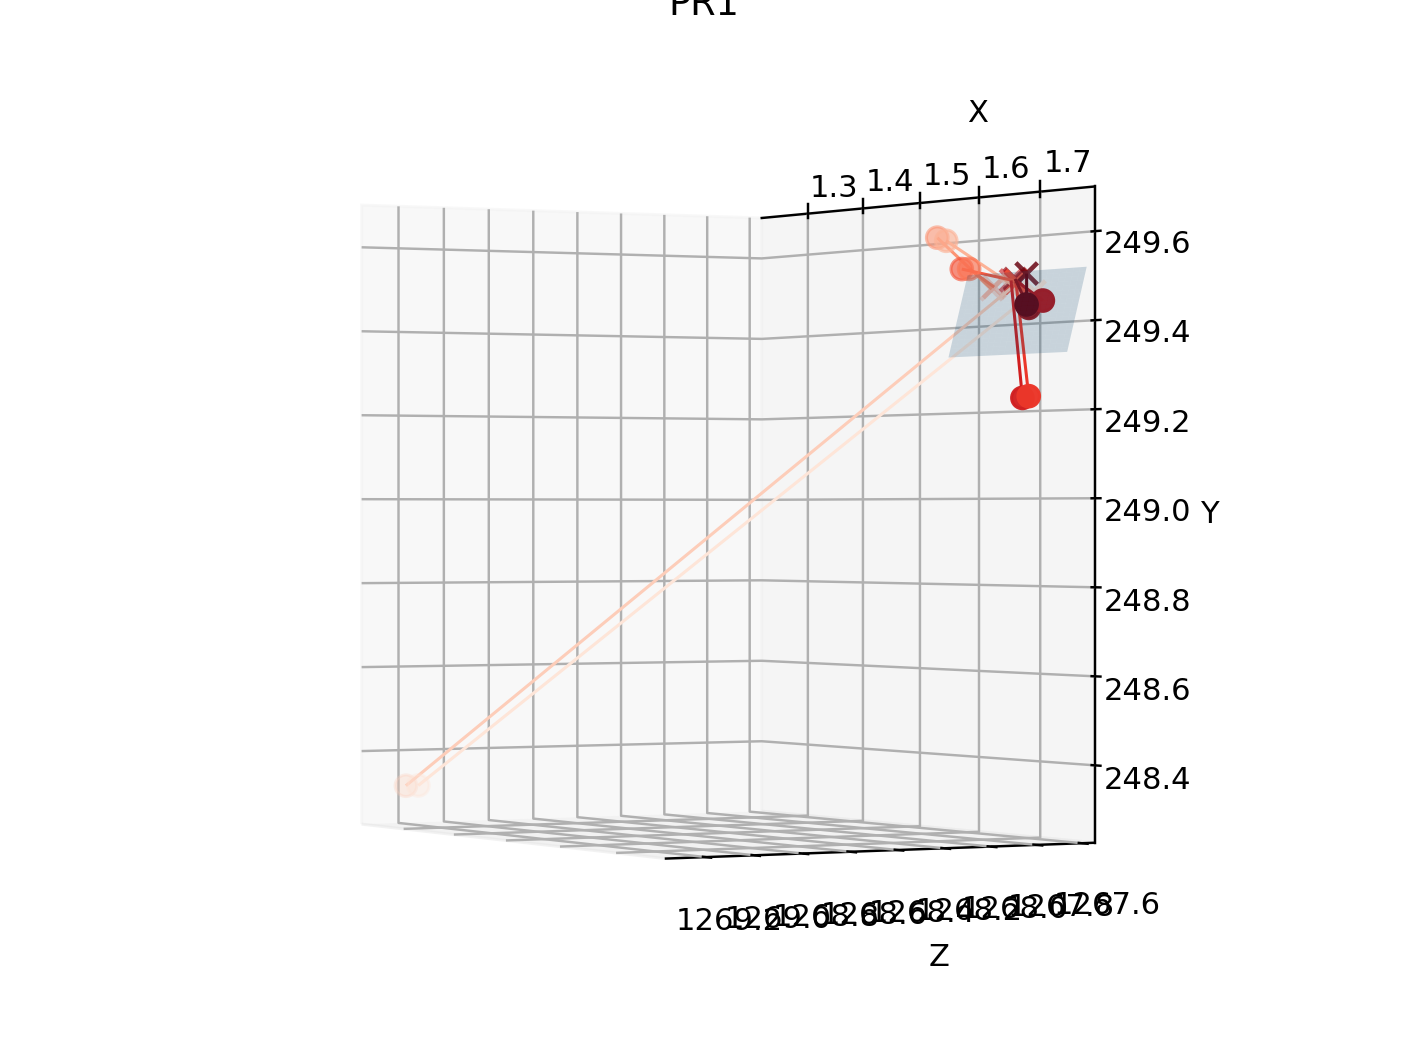

PR1
     uvec_dx     uvec_dy      uvec_dz
0   1.745698  249.466056  1267.695851
5   1.714051  249.476754  1267.712207
7   1.716521  249.483146  1267.712026
12  1.684313  249.476954  1267.716808
14  1.687255  249.481479  1267.713743
19  1.722047  249.491490  1267.709541
21  1.721042  249.488124  1267.709454
26  1.711398  249.494440  1267.705086
28  1.719334  249.493789  1267.706729
33  1.717006  249.497464  1267.702568
35  1.731828  249.508148  1267.692475
Radius of sphere that englobes all points (mm)
0.038432826846010903


<IPython.core.display.Javascript object>


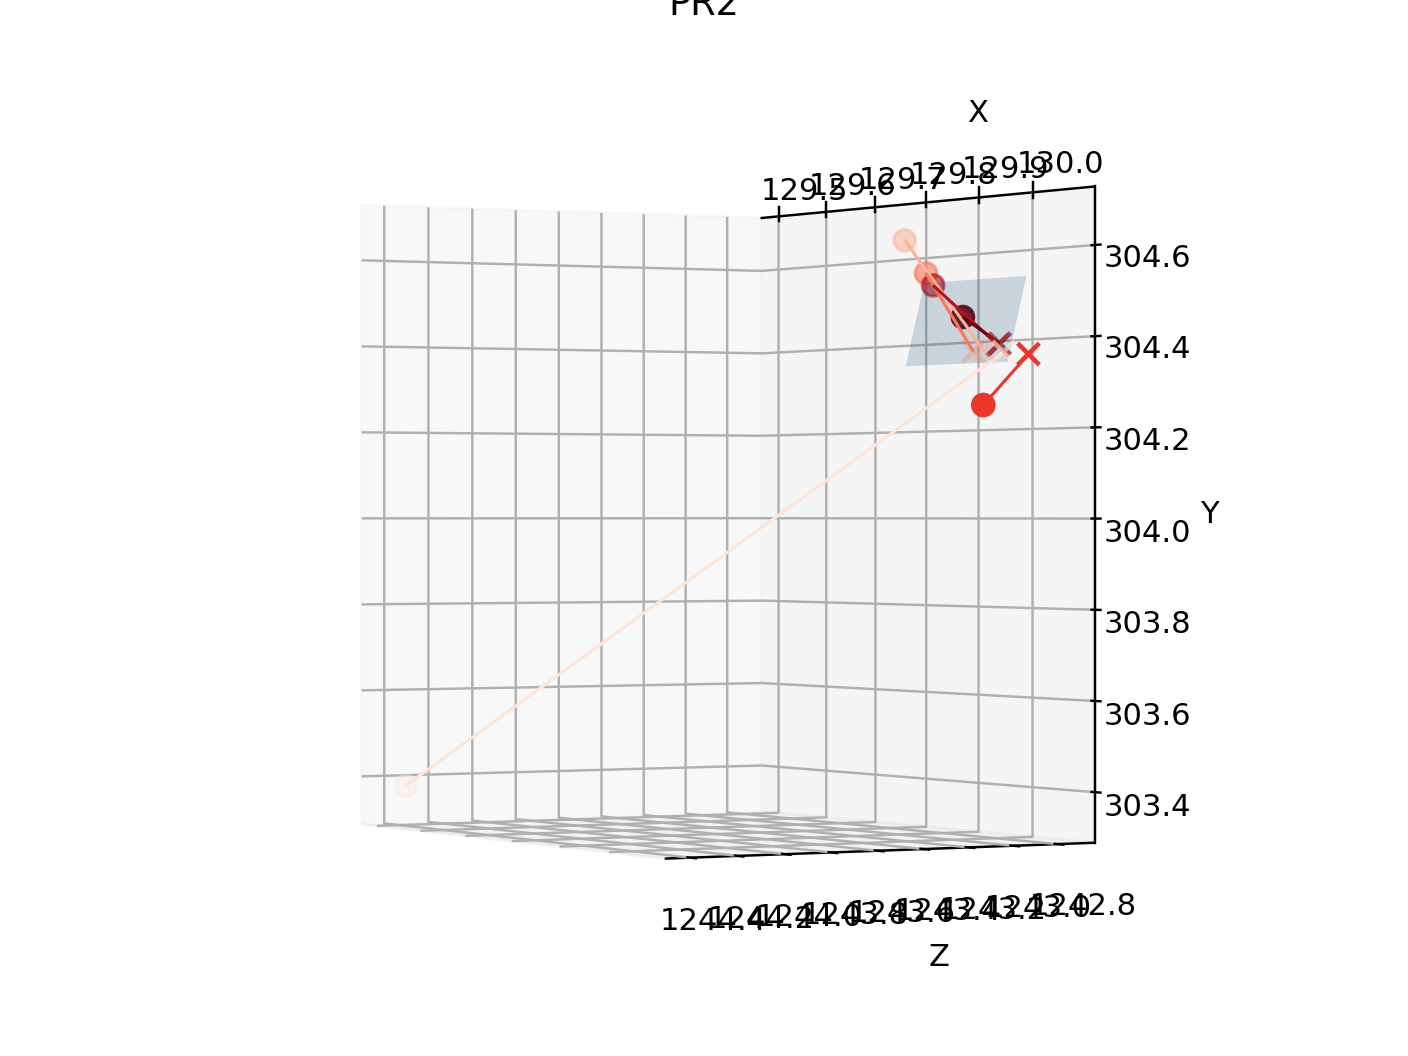

PR2
       uvec_dx     uvec_dy      uvec_dz
1   130.020854  304.369009  1242.817980
8   129.989807  304.374563  1242.831301
15  129.972006  304.372715  1242.833784
22  130.069774  304.361525  1242.827768
29  130.013072  304.385364  1242.825022
36  130.013054  304.388049  1242.815517
Radius of sphere that englobes all points (mm)
0.05836227301205912


<IPython.core.display.Javascript object>


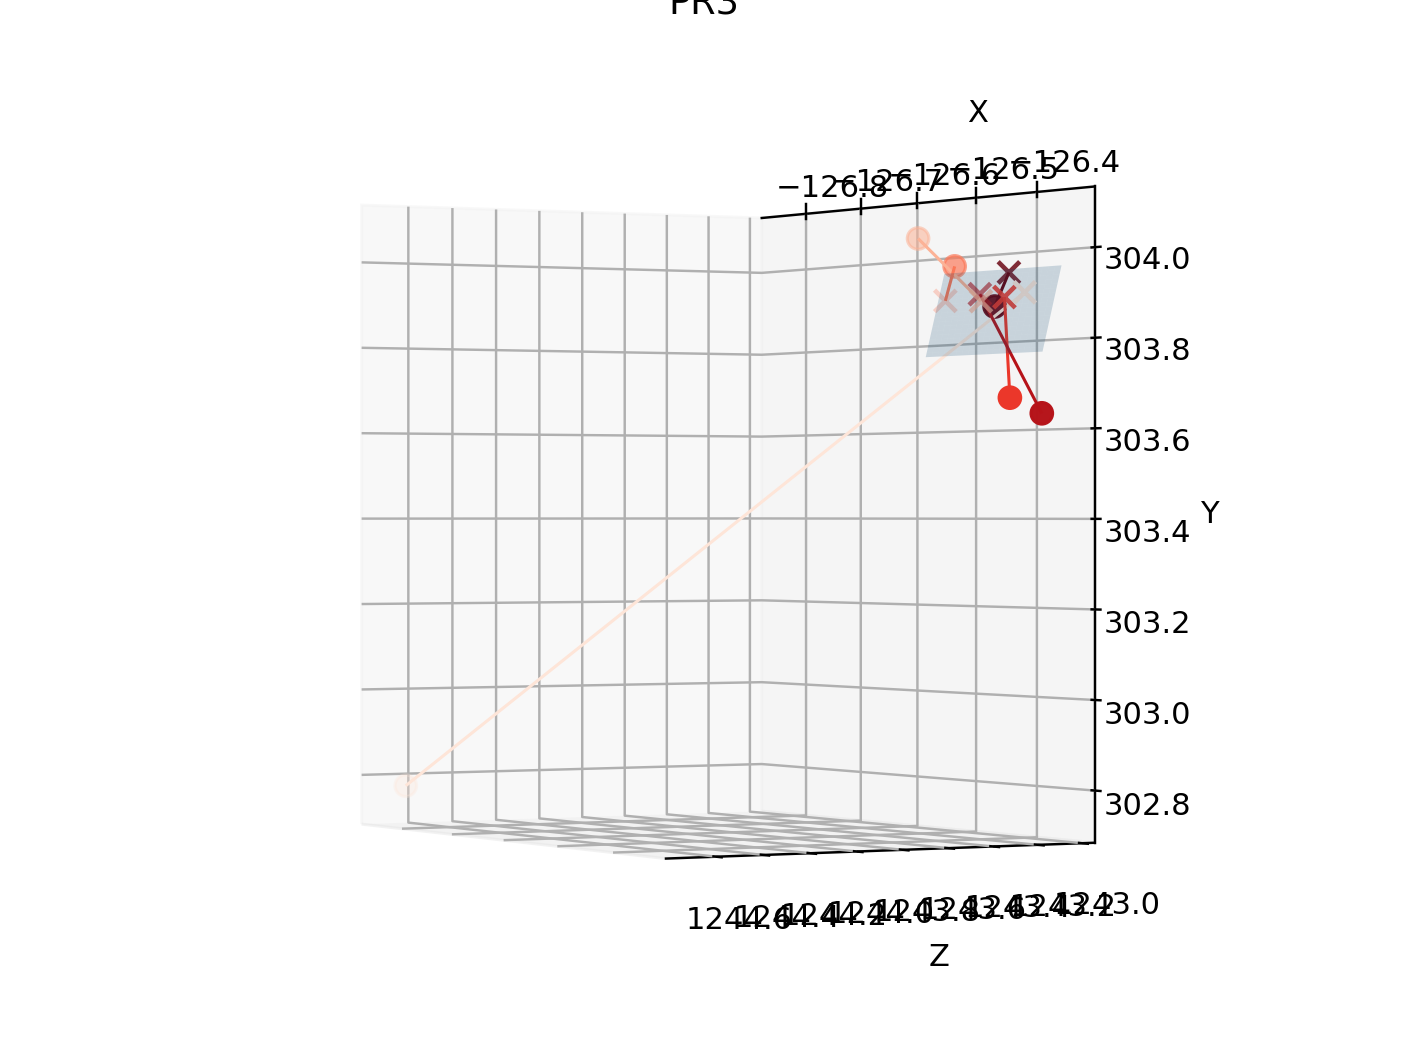

PR3
       uvec_dx     uvec_dy      uvec_dz
2  -126.345019  303.901159  1243.155126
9  -126.402485  303.886213  1243.192253
16 -126.468636  303.892697  1243.171853
23 -126.366436  303.892146  1243.186446
30 -126.411250  303.902735  1243.172798
37 -126.374507  303.948001  1243.143253
Radius of sphere that englobes all points (mm)
0.07476342432653231


<IPython.core.display.Javascript object>


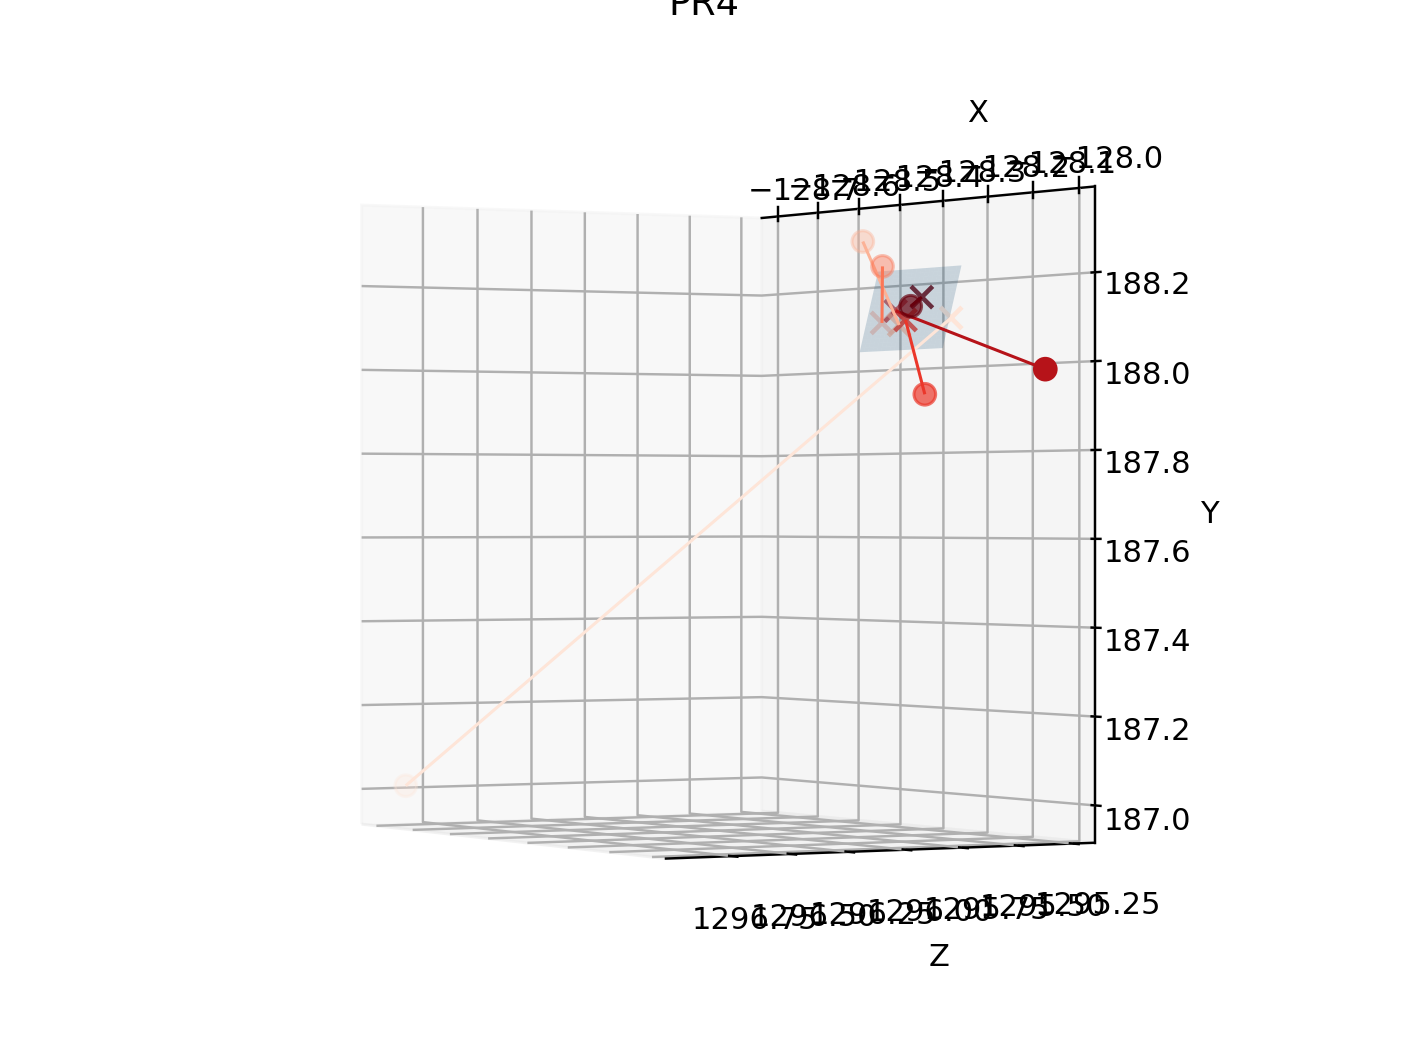

PR4
       uvec_dx     uvec_dy      uvec_dz
3  -128.192174  188.108903  1295.336118
10 -128.258226  188.095234  1295.442575
17 -128.303925  188.103006  1295.430556
24 -128.238760  188.105605  1295.452237
31 -128.263176  188.128635  1295.448975
38 -128.225068  188.158359  1295.404502
Radius of sphere that englobes all points (mm)
0.09974612328867112


<IPython.core.display.Javascript object>


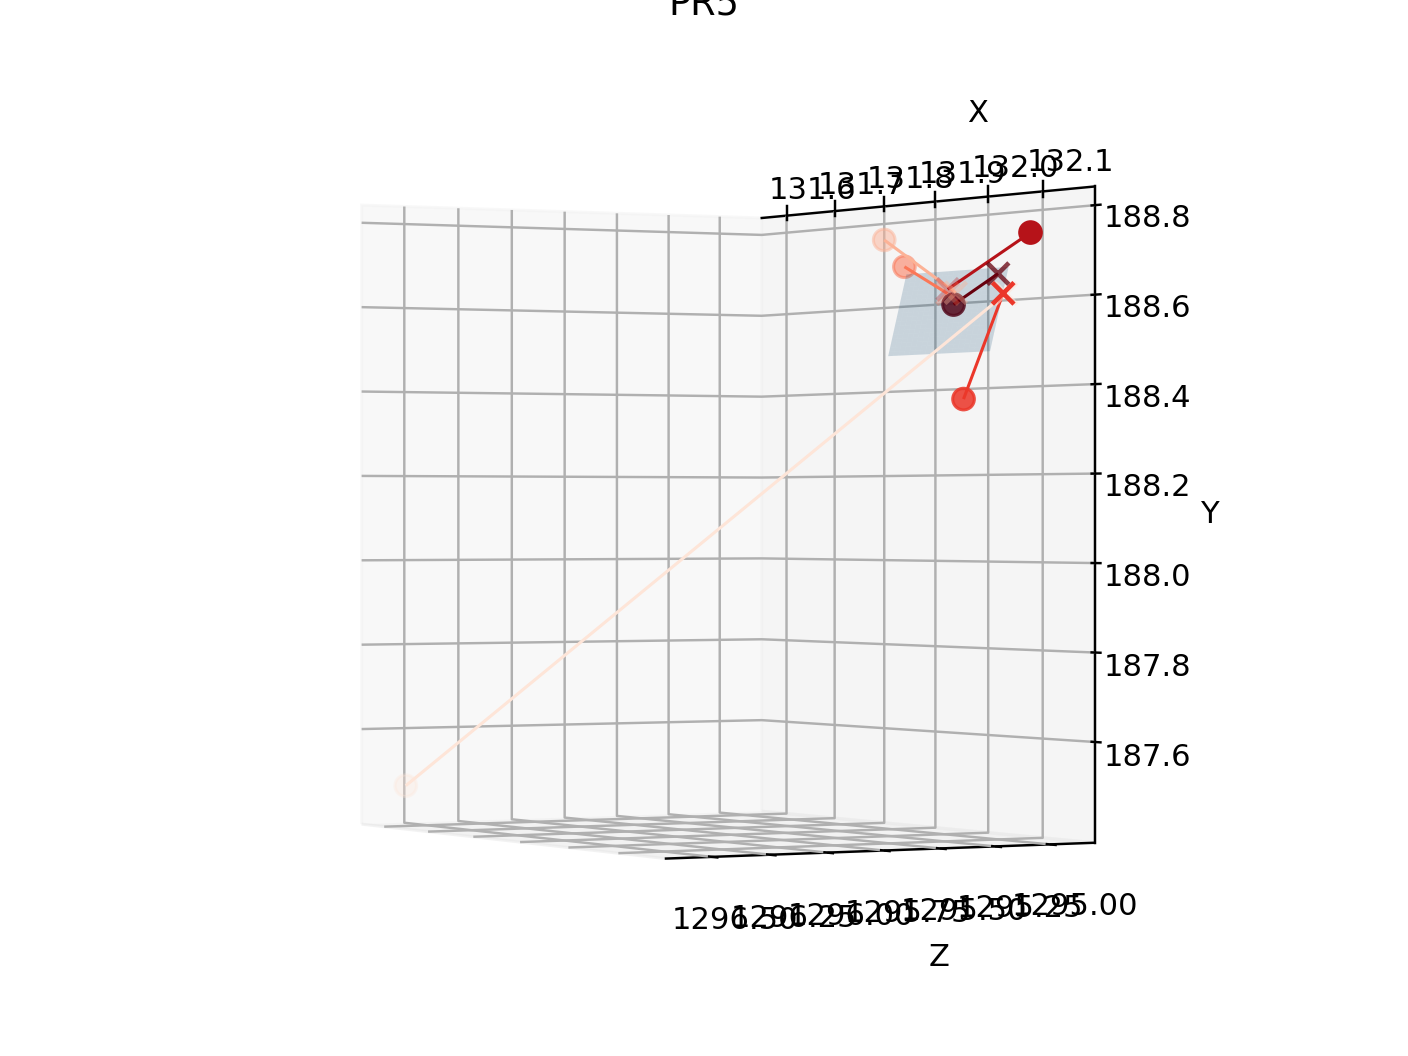

PR5
       uvec_dx     uvec_dy      uvec_dz
4   132.107138  188.607222  1294.983195
11  132.060427  188.611434  1295.097769
18  132.049364  188.610187  1295.107598
25  132.151185  188.602561  1295.108353
32  132.047560  188.620110  1295.102679
39  132.121727  188.649772  1295.056624
Radius of sphere that englobes all points (mm)
0.09498178742524138


In [12]:
for camera in [f'PR{i}' for i in range(1,6)]:
    subset = summary_5DOF[summary_5DOF['camera']==camera]
    ax = plot_whiskers(subset)
    meanloc = subset[['uvec_dx','uvec_dy','uvec_dz']].mean()
    ax.set_title(camera)
    print(camera)
    print(subset[['uvec_dx','uvec_dy','uvec_dz']])
    print('Radius of sphere that englobes all points (mm)')
#     print(np.amax(pdist((subset[['uvec_dx','uvec_dy','uvec_dz']]-meanloc).values.astype(float))))
    print(np.amax(np.linalg.norm((subset[['uvec_dx','uvec_dy','uvec_dz']]-meanloc).values.astype(float),axis=1)))
    plot_local_PR(df,ax,camera)
    

In [13]:
np.amax(np.linalg.norm((subset[['uvec_dx','uvec_dy','uvec_dz']]).values.astype(float),axis=1))

1315.4240794259854